In [38]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras import backend
import glob

In [4]:
files = glob.glob('/kaggle/input/medical-mnist/**/*.jpeg', recursive = True)

In [5]:
len(files)

58954

# Importando os dados:

In [6]:
df = pd.DataFrame({'path': files})
df.head()

,path
0,/kaggle/input/medical-mnist/AbdomenCT/003646.jpeg
1,/kaggle/input/medical-mnist/AbdomenCT/003998.jpeg
2,/kaggle/input/medical-mnist/AbdomenCT/001273.jpeg
3,/kaggle/input/medical-mnist/AbdomenCT/001609.jpeg
4,/kaggle/input/medical-mnist/AbdomenCT/007646.jpeg


In [7]:
df['path'][0]

'/kaggle/input/medical-mnist/AbdomenCT/003646.jpeg'

In [8]:
df['class'] = df['path'].apply(lambda x: x.split('/')[4])
df.head()

,path,class
0,/kaggle/input/medical-mnist/AbdomenCT/003646.jpeg,AbdomenCT
1,/kaggle/input/medical-mnist/AbdomenCT/003998.jpeg,AbdomenCT
2,/kaggle/input/medical-mnist/AbdomenCT/001273.jpeg,AbdomenCT
3,/kaggle/input/medical-mnist/AbdomenCT/001609.jpeg,AbdomenCT
4,/kaggle/input/medical-mnist/AbdomenCT/007646.jpeg,AbdomenCT


# Separando Treino e Teste:

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['path'] , df['class'], test_size = 0.1)
len(X_train)

53058

In [11]:
len(X_test)

5896

In [12]:
BATCH_SIZE = 128
data_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.15)
df_train = pd.concat([X_train, y_train], axis = 1)
df_train.head()

,path,class
56517,/kaggle/input/medical-mnist/ChestCT/008553.jpeg,ChestCT
27441,/kaggle/input/medical-mnist/Hand/007713.jpeg,Hand
29832,/kaggle/input/medical-mnist/CXR/003712.jpeg,CXR
15501,/kaggle/input/medical-mnist/BreastMRI/006036.jpeg,BreastMRI
9219,/kaggle/input/medical-mnist/AbdomenCT/003045.jpeg,AbdomenCT


# Definição da arquitetura:

In [13]:
train_generator = data_generator.flow_from_dataframe(dataframe = df_train, x_col = 'path', y_col = 'class', 
                                                     class_mode = 'categorical', batch_size = BATCH_SIZE, 
                                                     target_size = (64,64), subset = 'training', color_mode = 'rgb')
valid_generator = data_generator.flow_from_dataframe(dataframe = df_train, x_col = 'path', y_col = 'class', 
                                                     class_mode = 'categorical', batch_size = BATCH_SIZE, 
                                                     target_size = (64,64), subset = 'validation', color_mode = 'rgb')

Found 45100 validated image filenames belonging to 6 classes.
Found 7958 validated image filenames belonging to 6 classes.


In [16]:
def build_model2(shape):
    '''
    Constroi as camadas da rede
    :return: modelo construido
    '''

    base_model = MobileNetV2(weights = "imagenet", include_top = False, input_shape = shape)
    # congelando camadas que não iremos treinar.
    # para congelar alguns layers específicos basta passar o indice: for layer in mobile.layers[:5]:
    for layer in base_model.layers[:3]:
        layer.Trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    predictions = layers.Dense(6, activation = 'softmax')(x)

    model = Model(base_model.input, predictions)

    return model

In [17]:
model = build_model2((64,64,3))

9406464/9406464 [==============================] - 0s 0us/step


In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 32, 32, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 32, 32, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 32, 32, 32)   0           ['bn_Conv1[0][0]']               
                                                                                              

# Compilação:

In [19]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [21]:
checkpoint = ModelCheckpoint('medical_image_model.hdf5', monitor = 'val_loss', verbose = 1, mode = 'min', 
                             save_best_only = True)

In [22]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 5, mode = 'min', verbose = 1)

# Treinamento:

In [23]:
model.fit(train_generator, callbacks = [checkpoint, early_stop], steps_per_epoch = train_generator.samples//BATCH_SIZE,
          validation_data = valid_generator,
          validation_steps = valid_generator.samples//BATCH_SIZE, epochs = 20)

Epoch 1/20
352/352 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.9947
Epoch 1: val_loss improved from inf to 1.12207, saving model to medical_image_model.hdf5
352/352 [==============================] - 450s 1s/step - loss: 0.0176 - accuracy: 0.9947 - val_loss: 1.1221 - val_accuracy: 0.9211
Epoch 2/20
352/352 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 0.9991
Epoch 2: val_loss did not improve from 1.12207
352/352 [==============================] - 302s 858ms/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 7.8045 - val_accuracy: 0.6729
Epoch 3/20
352/352 [==============================] - ETA: 0s - loss: 0.0099 - accuracy: 0.9979
Epoch 3: val_loss improved from 1.12207 to 0.97849, saving model to medical_image_model.hdf5
352/352 [==============================] - 301s 854ms/step - loss: 0.0099 - accuracy: 0.9979 - val_loss: 0.9785 - val_accuracy: 0.9250
Epoch 4/20
352/352 [==============================] - ETA: 0s - loss: 0.0052 - ac

In [24]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [28]:
test_imgs = [img_to_array(load_img(im_path, color_mode = 'rgb')) for im_path in X_test]

In [30]:
y_pred = model.predict(np.array(test_imgs))

185/185 [==============================] - 7s 40ms/step


In [31]:
y_pred.argmax(axis = 1)

array([5, 4, 4, ..., 4, 4, 5])

# Avaliação:

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
y_test.values

array(['HeadCT', 'Hand', 'Hand', ..., 'AbdomenCT', 'HeadCT', 'HeadCT'],
      dtype=object)

In [34]:
y_test.head(10)

47778       HeadCT
25618         Hand
23255         Hand
35252          CXR
40338       HeadCT
8401     AbdomenCT
6303     AbdomenCT
55706      ChestCT
11972    BreastMRI
3114     AbdomenCT
Name: class, dtype: object

In [35]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['ChestCT', 'Hand', 'AbdomenCT', 'BreastMRI', 'HeadCT', 'CXR'])
y_teste = le.fit_transform(y_test)
y_teste

array([5, 4, 4, ..., 0, 5, 5])

In [42]:
cm = confusion_matrix(y_teste, y_pred.argmax(axis = 1))
cm

array([[   0,    0,    0,    0, 1029,    0],
       [   0,  542,   52,    0,   83,  242],
       [   0,    2,   11,    0,  942,    2],
       [   0,    0,    0,   32,  946,    4],
       [   0,    1,    8,    1,  927,   66],
       [   0,    0,    0,    1,  402,  603]])

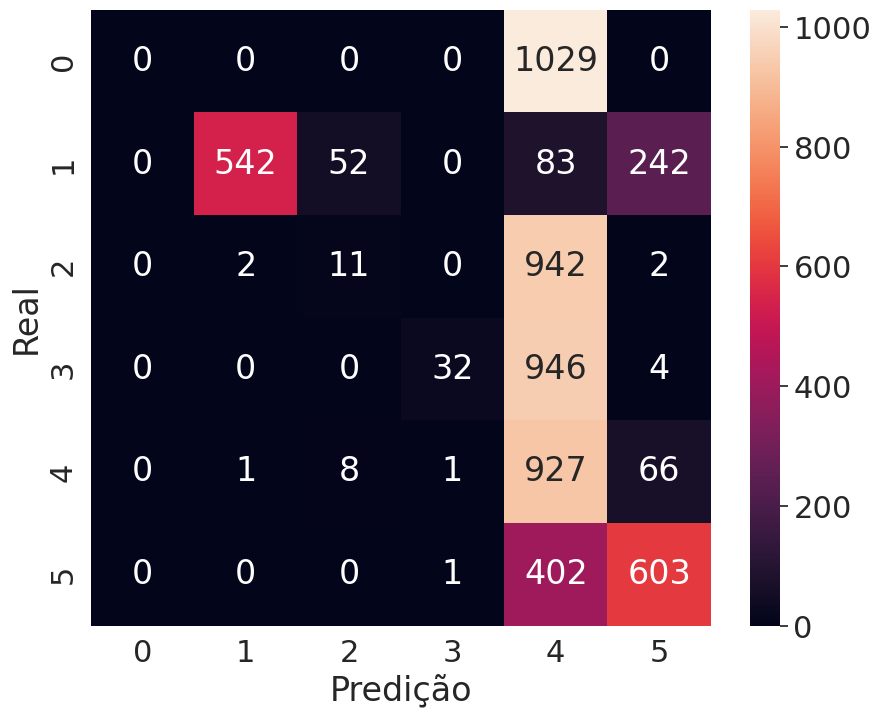

In [39]:
import seaborn as sns

plt.figure(figsize = (10, 8))
sns.set(font_scale = 2)
sns.heatmap(cm, annot = True, fmt = "d").set(xlabel = "Predição", ylabel = "Real");